In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp 
from jax import random, jit

# Build a transition kernel

In this series of notebooks we use logistic regression as the example. However the usage is exactly the same for other models.

In [2]:
# import model and create dataset
from sgmcmcjax.models.logistic_regression import gen_data, loglikelihood, logprior

key = random.PRNGKey(42)
dim = 10
Ndata = 100000 

theta_true, X, y_data = gen_data(key, dim, Ndata)

data = (X, y_data)

generating data, with N=100000 and dim=10


Here we build the transition kernel for sgld given some hyperparameters such as step size and batch size

In [3]:
from sgmcmcjax.kernels import build_sgld_kernel
from tqdm.auto import tqdm

batch_size = int(0.01*X.shape[0])
dt = 1e-5

init_fn, my_kernel, get_params = build_sgld_kernel(dt, loglikelihood, logprior, data, batch_size)
my_kernel = jit(my_kernel)

If we build the kernel function we also get `init_fn` and `get_params`. `init_fn` takes in a random key and the inital parameters and returns the state of the sampler. `get_params` takes in state and returns the current parameter. So we will pass `state` into the transition kernel to update it.

We can now write the loop ourselves and update the state using kernel function. Note that we must also split the random key, and save the samples ourselves. 

Writing the loop manually is useful if we want to do things like calculate the accuracy on a test dataset throughout the sampling.

In [4]:
%%time

key = random.PRNGKey(0)
Nsamples = 1000
samples = []

key, subkey = random.split(key)
state = init_fn(subkey, theta_true)

for i in tqdm(range(Nsamples)):
    key, subkey = random.split(key)
    state = my_kernel(i, subkey, state)
    samples.append(get_params(state))
    
samples = np.array(samples)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1.96 s, sys: 46.3 ms, total: 2.01 s
Wall time: 2.01 s


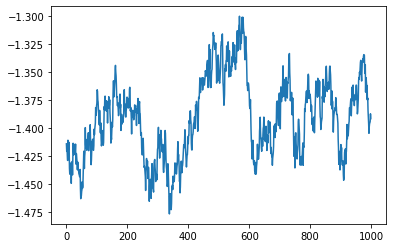

In [5]:

plt.plot(samples[:,0])